# 7. Наивный Байес и Классификация текстов

> Байесовские алгоритмы для классификации текстов  
> Извлечение признаков из текста

1. Скачайте этот ноутбук к себе.
2. Заполните пропущенные ячейки, отвечая на заданные вопросы. Там должен быть код! (если не сказано обратное)
3. Сохраните результат в своём гитхаб репозитории.

### Полезная литература

- [Naive Bayes and Text Classification](https://sebastianraschka.com/Articles/2014_naive_bayes_1.html)
- [ODS - классификация](https://habrahabr.ru/company/ods/blog/322534/)
- [Байесовский классификатор](http://www.machinelearning.ru/wiki/index.php?title=%D0%91%D0%B0%D0%B9%D0%B5%D1%81%D0%BE%D0%B2%D1%81%D0%BA%D0%B8%D0%B9_%D0%BA%D0%BB%D0%B0%D1%81%D1%81%D0%B8%D1%84%D0%B8%D0%BA%D0%B0%D1%82%D0%BE%D1%80)
- [Интересная статья про спам/не спам](https://habrahabr.ru/post/252265/)

Если вам понравилась задача распознавания текстов, то вот подборочка:

- [библиотека Gensim](https://radimrehurek.com/gensim/)
- [библиотека nltk](http://www.nltk.org/)
- [Лекция про word2vec 🔥](https://www.youtube.com/watch?v=oBb9aFmp0Hs)
- [Лекция Векторные представления слов и документов 🔥](https://www.youtube.com/watch?v=hiDBnEyoZS4)

## Наивный байесовский классификатор

На практике мы использовали его для детекции спам/не спам. В этот раз вы будете классифицировать [новостные тексты](https://scikit-learn.org/0.19/datasets/twenty_newsgroups.html). Попробуете разные методы  генерации признаков из текстов.

In [1]:
from sklearn.datasets import fetch_20newsgroups
newsgroups_train = fetch_20newsgroups(subset='train', remove=('headers', 'footers', 'quotes'))
newsgroups_train.target_names

['alt.atheism',
 'comp.graphics',
 'comp.os.ms-windows.misc',
 'comp.sys.ibm.pc.hardware',
 'comp.sys.mac.hardware',
 'comp.windows.x',
 'misc.forsale',
 'rec.autos',
 'rec.motorcycles',
 'rec.sport.baseball',
 'rec.sport.hockey',
 'sci.crypt',
 'sci.electronics',
 'sci.med',
 'sci.space',
 'soc.religion.christian',
 'talk.politics.guns',
 'talk.politics.mideast',
 'talk.politics.misc',
 'talk.religion.misc']

### 2.1 Загрузка данных (2 балла)

Мы будем использовать только 4 класса текстов: `'alt.atheism', 'sci.space', 'talk.religion.misc', 'comp.graphics'`.

Загрузите тренировочную и тестовую части датасета для этих категорий.

In [2]:
categories = ['alt.atheism','comp.graphics',\
               'sci.space','talk.religion.misc']

In [3]:
data = fetch_20newsgroups(subset='all',
    categories=categories, remove=('headers', 'footers', 'quotes'))#, shuffle=True, random_state=42)

In [4]:
data.target_names

['alt.atheism', 'comp.graphics', 'sci.space', 'talk.religion.misc']

Выведите по 1 тексту для каждой из категории.

In [5]:
import pandas as pd

In [6]:
def to_dataframe(data):

    df = pd.DataFrame([data.data, data.target.tolist()]).T
    df.columns = ['text', 'target']

    targets = pd.DataFrame(data.target_names)
    targets.columns=['category']

    out = pd.merge(df, targets, left_on='target', right_index=True)
    return out

In [7]:
def load_data(categories = ['alt.atheism','comp.graphics','sci.space','talk.religion.misc'],to_df=True):
    data = fetch_20newsgroups(subset='all',
    categories=categories, remove=('headers', 'footers', 'quotes'))#, shuffle=True, random_state=42)    
    if to_df:
        data = to_dataframe(data)  
    return data

In [519]:
df = load_data()

In [9]:
df.head()

,text,target,category
0,My point is that you set up your views as the ...,0,alt.atheism
9,"\n]The ""corrupted over and over"" theory is pr...",0,alt.atheism
14,"\n\nBut, you wouldn't know what red *was*, and...",0,alt.atheism
26,\n\nWell I agree with you in the sense that th...,0,alt.atheism
27,"\n\nSpecifically, which changes are you talkin...",0,alt.atheism


In [10]:
for cat in df.category.unique():
    row = df[df['category']==cat].head(1)
    print('Category({}): {}\n'.format(row['target'][:1].values[0],cat))  
    print(row['text'][:1].values[0])
    print('-----------------')

Category(0): alt.atheism

My point is that you set up your views as the only way to believe.  Saying 
that all eveil in this world is caused by atheism is ridiculous and 
counterproductive to dialogue in this newsgroups.  I see in your posts a 
spirit of condemnation of the atheists in this newsgroup bacause they don'
t believe exactly as you do.  If you're here to try to convert the atheists 
here, you're failing miserably.  Who wants to be in position of constantly 
defending themselves agaist insulting attacks, like you seem to like to do?!
I'm sorry you're so blind that you didn't get the messgae in the quote, 
everyone else has seemed to.
-----------------
Category(1): comp.graphics


By '8 grey level images' you mean 8 items of 1bit images?
It does work(!), but it doesn't work if you have more than 1bit
in your screen and if the screen intensity is non-linear.

With 2 bit per pixel; there could be 1*c_1 + 4*c_2 timing,
this gives 16 levels, but they are linear if screen intensity

### 2.2 Мешок слов (6 баллов)

Начнем с самого простого способа извлечения признаков из текстов: обычный подсчет количества употреблений слов в тексте.

Для этого используем [sklearn.feature_extraction.text.CountVectorizer](http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html). Настройте его так, чтобы он использовал англиские стоп слова.

Проведите трансформаци текстов из обоих датасетов и выведите размер полученного словаря. (1 векторайзер для тестового и тренировочного датасета! У вас должны получиться матрицы с одинаковыми признаками-словами)

In [11]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split

In [12]:
X = df['text']
y = df['target'].astype('int')

In [13]:
X_train_orig, X_test_orig, y_train, y_test = train_test_split(X, y, random_state=42, test_size=0.3, stratify=y)

In [14]:
vectorizer = CountVectorizer(stop_words='english')
X_train = vectorizer.fit_transform(X_train_orig)
X_test = vectorizer.transform(X_test_orig)

In [15]:
print("Количество слов в словаре: ", len(vectorizer.vocabulary_))
X_train.shape

Количество слов в словаре:  28395


(2370, 28395)

Будем использовать классифиактор для мультиклассифкации [sklearn.naive_bayes.MultinomialNB]().

- Проведите кроссвалидацию на 5 фолдах для метрики `accuracy`.
- обучите на тренировочных данных, 
- нарисуйте красивую confusion матрицу, (с именами классов, а не индексами по осям)
- выведите отчет классификации для тестовой выборки (с именами классов, а не индексами)

In [16]:
from sklearn.model_selection import cross_val_score, GridSearchCV, StratifiedKFold
from sklearn.naive_bayes import MultinomialNB

In [17]:
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import plot_confusion_matrix

In [18]:
import numpy as np
import matplotlib.pyplot as plt

In [19]:
params = {
            "alpha": [1,2,3,4,5,6,10], 
         }

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
search = GridSearchCV(MultinomialNB(), params, cv=cv, verbose=0,n_jobs=-1, scoring='accuracy')                    

%time search.fit(X_train, y_train)

CPU times: user 264 ms, sys: 58 ms, total: 322 ms
Wall time: 4.03 s


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
             error_score=nan,
             estimator=MultinomialNB(alpha=1.0, class_prior=None,
                                     fit_prior=True),
             iid='deprecated', n_jobs=-1,
             param_grid={'alpha': [1, 2, 3, 4, 5, 6, 10]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring='accuracy', verbose=0)

In [20]:
print("BEST: score={}, params={}".format(search.best_score_, search.best_params_))

BEST: score=0.8101265822784809, params={'alpha': 1}


In [21]:
clf = MultinomialNB(alpha=search.best_params_['alpha'])
clf.fit(X_train, y_train)

MultinomialNB(alpha=1, class_prior=None, fit_prior=True)

In [22]:
y_pred = clf.predict(X_test)

In [23]:
#Категории для лейблов матрицы ошибок
class_names = df.groupby(['target','category']).count().reset_index().category.values
class_names

array(['alt.atheism', 'comp.graphics', 'sci.space', 'talk.religion.misc'],
      dtype=object)

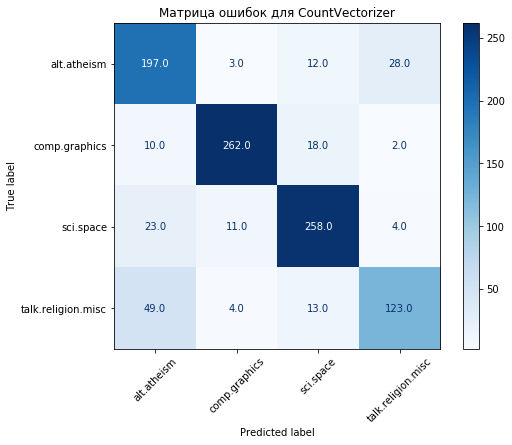

In [24]:
fig, ax = plt.subplots(figsize=(8, 6))
np.set_printoptions(precision=2)
disp = plot_confusion_matrix(clf, X_test, y_test,
                                 display_labels=class_names,
                                 cmap=plt.cm.Blues,
                                 normalize=None, ax=ax, values_format='.1f',)

disp.ax_.set_title('Матрица ошибок для CountVectorizer')
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names, rotation=45)
plt.show()

In [25]:
print('CountVectorizer\n\n')
print(classification_report(y_test, y_pred, target_names=class_names))

CountVectorizer


                    precision    recall  f1-score   support

       alt.atheism       0.71      0.82      0.76       240
     comp.graphics       0.94      0.90      0.92       292
         sci.space       0.86      0.87      0.86       296
talk.religion.misc       0.78      0.65      0.71       189

          accuracy                           0.83      1017
         macro avg       0.82      0.81      0.81      1017
      weighted avg       0.83      0.83      0.83      1017



--------------- Проверка---------------

Как проверить, что лейблы выставлены правильно? Можно взять количество значений по группам в y_test, просуммировать значения в confusion_matrix по горизонтали, тем самым определив индекс метки, затем по индексу сравнить с df.  

Пример: сумма в 296 в матрице это 3 строка, лейбл указан sci.space, индекс в y_test с 296 == 2, что соответствует sci.space из df

In [26]:
y_test.value_counts()

2    296
1    292
0    240
3    189
Name: target, dtype: int64

In [27]:
df.groupby(['target','category']).count()

,,text
target,category,
0,alt.atheism,799
1,comp.graphics,973
2,sci.space,987
3,talk.religion.misc,628


--------------- Проверка завершена---------------

Добавлю сохранение предыдущего отчета, для сравнения с новым

In [191]:
def report2array(cr,rows=4):
    # classification_report to array
    tmp = list()
    m_avg=0
    r_num=0
    for row in cr.split("\n"):
        if (0 != r_num) and (r_num <= rows+1): #от 2 до 5 строки
            parsed_row = [float(x) for x in row.split("  ") if len(x) > 0]
            if len(parsed_row) > 0:
                tmp.append(parsed_row[1:4])
        if r_num == rows+1+3: # 8 строка macro avg
            parsed_row = [x for x in row.split("  ") if len(x) > 0]
            if len(parsed_row) > 0:
                m_avg =  parsed_row[3]
                break
        r_num+=1
    return np.array(tmp), float(m_avg)

In [30]:
np.set_printoptions(precision=2)
#Сохраню текущие значения матрицы ошибок
cr_old, macro_avg_old = report2array(classification_report(y_test, y_pred))

In [31]:
cr_best, macro_avg_best = report2array(classification_report(y_test, y_pred))

In [192]:
# Посмотрим на ТОП 10 по важности слова в каждой категории

def show_top10(classifier, vectorizer, categories, top=10):
    feature_names = np.asarray(vectorizer.get_feature_names())
    for i, category in enumerate(categories):
        top10 = np.argsort(classifier.coef_[i])[-top:]
        print("%s: [%s]" % (category, " ".join(feature_names[top10])))

In [193]:
show_top10(clf, vectorizer, class_names)

alt.atheism: [exist moral atheist religious bible belief evidence atheists jesus atheism]
comp.graphics: [ftp data color files format software gif images file jpeg]
sci.space: [data mission launch lunar solar shuttle moon spacecraft orbit nasa]
talk.religion.misc: [father man word christian elohim christ lord bible jehovah jesus]


### 2.3 [Tf-IDF](https://ru.wikipedia.org/wiki/TF-IDF) (6 баллов) 

Мешок слов не учитывает "веса" слов, он просто смотрит их вхождение в документ. Вероятно, было бы полезно взвесить каким-то обраом каждое слово в документе. Действительно, если слово встречается во всех документах, то, наверное, его вес небольшой. А если редкое слово встречается в некоторых документах, то скорее всего оно какое-то узко тематическое.

Один из способов взвесить слова - это использовать меру tf-idf, где:

**TF - term frequency** - частота слова для каждой статьи

$$\LARGE \mathrm{tf}(t,d) = \frac{n_t}{\sum_k n_k}$$

**IDF - inverse document frequency*** — обратная частота документа - уменьшает вес часто встречаемых слов

$$\LARGE \mathrm{idf}(t, D) =  \log \frac{|D|}{|\{\,d_i \in D \mid t \in d_{i}\, \}|}$$

$D$ - число документов в корпусе

$|\{\,d_i \in D \mid t \in d_{i}\, \}|$ - число документов из коллекции ${\displaystyle D}$ , в которых встречается ${\displaystyle t}$  (когда ${\displaystyle n_{t}\neq 0}$ ).

**TF-IDF**

$$\LARGE \operatorname{tf-idf}(t,d,D) = \operatorname{tf}(t,d) \times \operatorname{idf}(t, D)$$


Для него есть класс [sklearn.feature_extraction.text.TfidfVectorizer](http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html)

- Проведите кроссвалидацию на 5 фолдах для метрики `accuracy`.
- обучите на тренировочных данных, 
- нарисуйте красивую confusion матрицу, (с именами классов, а не индексами по осям)
- выведите отчет классификации для тестовой выборки (с именами классов, а не индексами)

In [34]:
from sklearn.feature_extraction.text import TfidfTransformer

In [35]:
tfidf_transformer = TfidfTransformer()

https://stats.stackexchange.com/questions/154660/tfidfvectorizer-should-it-be-used-on-train-only-or-traintest  
https://stats.stackexchange.com/questions/344571/imputing-the-mean-value-from-the-train-set-into-the-test-set

In [36]:
X_tfidf_train = tfidf_transformer.fit_transform(X_train)
X_tfidf_test = tfidf_transformer.transform(X_test)

In [37]:
params = {
            "alpha": [1,2,3,4,5,6,10], 
         }

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
search = GridSearchCV(MultinomialNB(), params, cv=cv, verbose=0,n_jobs=-1, scoring='accuracy')                    

%time search.fit(X_tfidf_train, y_train)

CPU times: user 170 ms, sys: 12.4 ms, total: 183 ms
Wall time: 677 ms


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
             error_score=nan,
             estimator=MultinomialNB(alpha=1.0, class_prior=None,
                                     fit_prior=True),
             iid='deprecated', n_jobs=-1,
             param_grid={'alpha': [1, 2, 3, 4, 5, 6, 10]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring='accuracy', verbose=0)

In [38]:
print("BEST: score={}, params={}".format(search.best_score_, search.best_params_))

BEST: score=0.7616033755274261, params={'alpha': 1}


In [39]:
clf = MultinomialNB(alpha=search.best_params_['alpha'])
clf.fit(X_tfidf_train, y_train)

y_pred_tfidf = clf.predict(X_tfidf_test)

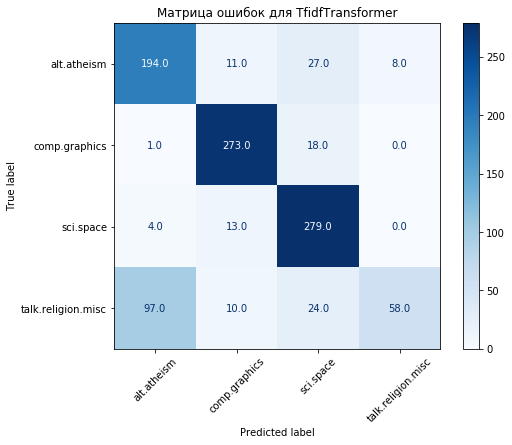

In [40]:
fig, ax = plt.subplots(figsize=(8, 6))
np.set_printoptions(precision=2)
disp = plot_confusion_matrix(clf, X_tfidf_test, y_test,
                                 display_labels=class_names,
                                 cmap=plt.cm.Blues,
                                 normalize=None, ax=ax, values_format='.1f',)

disp.ax_.set_title('Матрица ошибок для TfidfTransformer')
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names, rotation=45)
plt.show()

In [41]:
print('CountVectorizer + tfidf\n\n')
cur_rep = classification_report(y_test, y_pred_tfidf, target_names=class_names)
print(cur_rep)

CountVectorizer + tfidf


                    precision    recall  f1-score   support

       alt.atheism       0.66      0.81      0.72       240
     comp.graphics       0.89      0.93      0.91       292
         sci.space       0.80      0.94      0.87       296
talk.religion.misc       0.88      0.31      0.45       189

          accuracy                           0.79      1017
         macro avg       0.81      0.75      0.74      1017
      weighted avg       0.81      0.79      0.77      1017



In [42]:
cr_cur, macro_avg_cur = report2array(classification_report(y_test, y_pred_tfidf))

In [43]:
print('Разница в macro avg: {:.2f}\n'.format(macro_avg_cur-macro_avg_old))
print('Разница в показателях с предыдущим отчетом:\n\nprecision/recall/f1-score\n{}'.format(cr_cur - cr_old))

Разница в macro avg: -0.07

Разница в показателях с предыдущим отчетом:

precision/recall/f1-score
[[-0.05 -0.01 -0.04]
 [-0.05  0.03 -0.01]
 [-0.06  0.07  0.01]
 [ 0.1  -0.34 -0.26]]


Качество ухудшилось

In [44]:
show_top10(clf, vectorizer, class_names)

alt.atheism: [believe does atheism say religion just think people don god]
comp.graphics: [need looking format program know files file image thanks graphics]
sci.space: [think don just moon launch orbit shuttle like nasa space]
talk.religion.misc: [koresh know say bible just christian don people jesus god]


In [45]:
cr_old, macro_avg_old = report2array(classification_report(y_test, y_pred_tfidf))

### 2.4 В чём проблема? (7 баллов)

Как вы заметили, качество немного улучшилось. Как вы думаете почему у нас до сих пор есть ошибки? В чём проблема? Опирайтесь на вывод топа 10 важных слов, confusion matrix и репорт классификации.

**Задание**: Напишите развернутое рассуждение.

![](https://i.imgur.com/3D5pgrk.png)

Ответ: Основные "проблемы" с реглигией, во первых в атеизме часто встречаются слова из религии, во вторых почему то при определении космоса и графики часть путается с религией, при этом религия не путается с космосом и графикой. Это вероятно говорит о том, что в категории религии специфичные слова имеют бОльший вес, точнее описывают категорию, в отличии от космоса, где проскальзывают слова из религии с весом далеко не на дне. Показательно TN для религии и атеизма, вероятно всего это связано с общими/одинаковыми словами в этих темах, поэтому классификатору сложно их различать. В целом у темы космоса и графики хорошие показатели полноты, точность немного страдает, но если "разобраться" с религией, то думаю станет лучше. Конечно со словарем никак не работали, нужно убирать мусорные и общие слова во всех темах,  а так же проводить анализ словарей по категорям, особенно смотреть на топовые слова. Например из космоса можно убрать слова (think just like) и прочие подобные слова убрать вообще из всех категорий. Из атеизма можно убрать (god, religion), оставив только для религии.

Можно еще немного улучшить качество предсказания, если использовть n-граммы, то есть не только одиночные слова, но и пары, тройки. Для этого у векторайзера есть параметр `ngram_range`, но будьте осторожны, сгенерируется очень много признаков. Их количество можно ограничить  `max_features`. Ещё можно копать в сторону правильного процессинга текстов: лемматизация и стемминг, чтобы убирать окончания, но это обчно не сильно помогает в английском языке.

Кроме того можно было бы пойти совсем в другую сторону и использовать word-2-vec технологии, тогда бы у нас слова начал "обретать" смысл. Но это вовсем другая история.

### Дополнительная работа

##### Преобразование слов в хештеги

Посмотрим в целом на словарь. Много цифр, а так же есть слова с "_" вместо пробела.

Сначала разберусь с цифрами. 
 - Цифры состояшие из 4х символов заменю на #года + #века
 - Цифры по примеру 800x600.. заменю на #разрешение
 - все остальные цифры включая шаблоны выше заменю на #цифры
 - Цифры по примеру'6am' или '18:58' заменю на #время
 - Даты заменю на #date

In [194]:
import re

In [195]:
vectorizer.get_feature_names()[:500]

['00',
 '00 00',
 '00 01',
 '00 10',
 '00 11',
 '00 12',
 '00 21',
 '00 25',
 '00 26',
 '00 30',
 '00 47',
 '00 52',
 '00 899596754214342091e',
 '00 899999999999999858e',
 '00 additional',
 '00 advance',
 '00 afraid',
 '00 agree',
 '00 available',
 '00 book',
 '00 color',
 '00 dollars',
 '00 excellent',
 '00 fax',
 '00 federal',
 '00 fred',
 '00 gives',
 '00 hoe',
 '00 indications',
 '00 international',
 '00 jpeg',
 '00 jupiter',
 '00 lunch',
 '00 mail',
 '00 major',
 '00 non',
 '00 noon',
 '00 opening',
 '00 patent',
 '00 plus',
 '00 pm',
 '00 policy',
 '00 pounds',
 '00 produce',
 '00 proof',
 '00 pulsars',
 '00 purchase',
 '00 quality',
 '00 regents',
 '00 registration',
 '00 saturn',
 '00 saying',
 '00 shipping',
 '00 site',
 '00 spend',
 '00 students',
 '00 tar',
 '00 thank',
 '00 type',
 '00 upgrading',
 '00 ut',
 '00 yesterday',
 '000',
 '000 00',
 '000 000',
 '000 10',
 '000 40',
 '000 _never_',
 '000 atoms',
 '000 attempted',
 '000 bc',
 '000 believe',
 '000 bright',
 '000 buc

In [490]:
#дата
def GetDate (txt):  
    out = re.sub(r'\b\d+[:,\.]\d+[\.]\d+\b','##date',str(txt))
    return out

In [491]:
#года и века
def GetYearCentury (txt):
    def GetCentury (year):
        cen = re.findall(r'\b\d{2,2}',str(year)) #первые 2 числа
        cen = int(cen[0]) + 1
        return '##year ##centry{}'.format(cen)
    out =  re.sub(r'\b[1-2]{1}\d{3}\b',lambda y: GetCentury(y.group(0)),str(txt))
    return out

In [492]:
#разрешение экрана
def GetResolution (txt):  
    out = re.sub(r'\d+[x]\w+\b','##resolution',str(txt))
    return out

In [493]:
#размер файла
def GetFileSize (txt):  
    out = re.sub(r'\d+[m,M,M,b,B,k,K,K,g,G,G]{1,1}[b,B,y]{1,1}\b','##filesize',str(txt))
    return out

In [494]:
#какой то размер
def GetSomeSize (txt):  
    out = re.sub(r'\d+[a-z]{1,3}\b','##somesize',str(txt))
    return out

In [495]:
#время
def GetTime (txt):  
    out = re.sub(r'\d+:\d+[\w,:]+\b','##time',str(txt))
    return out

In [597]:
#сначала цифра/буква, затем буквы и/или цифры
def GetNumbAndLetters (txt):  
    out = re.sub(r'\d+[a-z]+\w+\b|[a-z]+\d+\w+\b','##numb_lett',str(txt))
    return out

In [497]:
#e-mail
def GetEmail (txt):  
    out = re.sub(r'[@]+[a-z0-9]+|[a-z0-9]+[@]+[a-z0-9]+\b','##email',str(txt))
    return out

In [498]:
#Phone
def GetPhone (txt):  
    out = re.sub(r'\d+[-][-\d]+|[-]\d+[-\d]+','##phone',str(txt))
    return out

In [499]:
#любые цифры, только цифры
def GetNumbOnly (txt):  
    out = re.sub(r'\b\d+\b','##numb',str(txt))
    return out

In [500]:
#слова на латинице от 3х букв
def GetEnWords (txt):
    txt = txt.replace('_','')
    #out = re.findall(r'\b[^#][a-z]{3,}\b',str(txt.replace('_',''))) #слова на латинице от 3х букв 
    out = re.sub(r'[^#0-9]\b[a-z]{1,3}\b','',str(txt))
    return out

In [603]:
def re_Parse(txt,cv_parse=True,tresh=True,cv_parse_only=False):
    def process(txt,cv_parse=True):
        if cv_parse:
            vectorizer_tmp = CountVectorizer(token_pattern=r'\b\w\w+\b|d+[-][-\d]+|[-]\d+[-\d]+|(?<!\w)@\w+|(?<!\w)##\w+')
            vectorizer_tmp.fit([txt])
            voc = vectorizer_tmp.get_feature_names()
            txt = ' '.join(voc)
            #print(txt+'\n\n')
        if (False == cv_parse_only):
            txt = GetDate(txt)
            txt = GetYearCentury(txt)
            txt = GetResolution(txt)
            txt = GetFileSize(txt)
            txt = GetSomeSize(txt)
            txt = GetTime(txt)
            txt = GetEmail(txt)
            txt = GetPhone(txt)
            txt = GetNumbAndLetters(txt)
            txt = GetNumbOnly(txt)
            txt = GetEnWords(txt)
        return txt
    if tresh:
        if len(txt.split(' ')) > 20: #Если слов в статье больше 20, то берем, иначе встречается ошибка ValueError: empty vocabulary; perhaps the documents only contain stop words
            txt = process(txt,cv_parse)
        else:
            txt=''
    else:
        txt = process(txt,cv_parse)
    return txt

In [599]:
#Для проверки работы регулярных выражений
re_check = ['00','0000','000005102000','0004246',
 '000062david42','1000k1','a0000',
 '000usd','101h','10km','2e','2nd','10m','10mhz','1500kg',
 '0x0','0xc010','1024x768','1024x768x24',
 '1951','2011','1000','1024', 
 '100mb','1GB','110mbytes',
 '15:25:64','6:52',
 '13.02.1999','13.02.99',
 '@andrew','123@article.com',
 'move','end', 'just', 'i',
 '#hashtag', '#hashtag',
 'FAX (904) 644-4214 or -0098' , '-800-377-8287',
 '_____________________',
 '___samuel___',
  ]
re_check = ' '.join(re_check)
re_Parse(re_check,tresh=False)

-0098 -4214 -800-377-8287 00 0000 000005102000 000062david42 0004246 000usd 02 0x0 0xc010 1000 1000k1 100mb 101h 1024 1024x768 1024x768x24 10km 10m 10mhz 110mbytes 123 13 15 1500kg 1951 1999 1gb 2011 25 2e 2nd 52 64 644 904 99 @andrew _____________________ ___samuel___ a0000 article com end fax hashtag just move or




'##phone ##phone ##phone ##numb ##numb ##numb ##numblett ##numb ##somesize ##numb ##resolution ##resolution ##year ####numblett ##numblett ##filesize ##somesize ##year ####numblett ##resolution ##resolution ##somesize ##somesize ##somesize ##numblett ##numb ##numb ##numb ##somesize ##year ####numblett ##year ####numblett ##filesize ##year ####numblett ##numb ##somesize ##somesize ##numb ##numb ##numb ##numb ##numb ##email  samuel ##numblett article hashtag just move'

Сформирую новый столбец с текстом, который будет содержать только слова, затем на основе него составлю новый словарь.

In [604]:
df['text_f3'] = df['text'].apply(lambda r: re_Parse(r,cv_parse=True,tresh=True,cv_parse_only=False))

In [605]:
#text_f3 == nan, это статьи, у которых мало текста или вообще нет или он состоит только из стоп слов
df.isnull().sum()

text        0
target      0
category    0
text_f3     0
dtype: int64

In [606]:
df.dropna(inplace=True)

In [607]:
df[['text','text_f3']].head()

,text,text_f3
0,My point is that you set up your views as the ...,agaist atheism atheists attacks bacause believ...
9,"\n]The ""corrupted over and over"" theory is pr...",all believe brothers changed closed comparison...
14,"\n\nBut, you wouldn't know what red *was*, and...",and applicable certainly couldn discuss judge ...
26,\n\nWell I agree with you in the sense that th...,adam agree almost around avoid behaviour best ...
27,"\n\nSpecifically, which changes are you talkin...",##numb about arguing changes interpreted large...


In [608]:
X = df['text_f3']
y = df['target'].astype('int')

In [609]:
X_train_orig, X_test_orig, y_train, y_test = train_test_split(X, y, random_state=42, test_size=0.3, stratify=y)

In [591]:
txt_tmp = df[df['text_f3'].str.contains('a0000')][['text_f3']]
txt_tmp

,text_f3
1380,##resolution ##resolution ##resolution a0000 a...
3141,##resolution ##resolution ##resolution a0000 a...


In [571]:
txt_tmp['text_f3'].apply(lambda r: re_Parse((r.replace('\'','')).replace('\"',''),cv_parse=True,tresh=True,cv_parse_only=False))

3020    \nOops, forgot the phone number.  Its 1-800-37...
Name: text_f3, dtype: object

In [512]:
df.loc[1153]['text_f3']

'This discussion is better followed in talk.politics.space\nJoseph Cain\t\tcain@geomag.gly.fsu.edu   \ncain@fsu.bitnet\t\tscri::cain\n(904) 644-4014\t\tFAX (904) 644-4214 or -0098\n'

In [610]:
vectorizer_f3 = CountVectorizer(token_pattern=r'\b\w\w+\b|d+[-][-\d]+|[-]\d+[-\d]+|(?<!\w)@\w+|(?<!\w)##\w+')
X_train_f3 = vectorizer_f3.fit_transform(X_train_orig)
X_test_f3 = vectorizer_f3.transform(X_test_orig)

!!! Почему не все цифры обработаны?

In [611]:
vectorizer_f3.get_feature_names()

['##all',
 '##but',
 '##ceived',
 '##centry',
 '##email',
 '##filesize',
 '##for',
 '##gone',
 '##had',
 '##holy',
 '##i',
 '##in',
 '##investigated',
 '##it',
 '##lems',
 '##numb',
 '##numblett',
 '##phone',
 '##pour',
 '##resolution',
 '##say',
 '##science',
 '##so',
 '##some',
 '##somesize',
 '##the',
 '##then',
 '##to',
 '##what',
 '##while',
 '##with',
 '##year',
 '10',
 '1r',
 '2s',
 '38',
 '45',
 'a3',
 'aacs',
 'aangeboden',
 'aangegeven',
 'aantal',
 'aantalsnijpunten',
 'aaoepp',
 'aaplay',
 'aarnet',
 'aaroundpluto',
 'aavso',
 'aawin',
 'ab',
 'abandon',
 'abandoned',
 'abandoning',
 'abandons',
 'abba',
 'abbreviated',
 'abbreviation',
 'abbreviations',
 'abbs',
 'abdel',
 'abducted',
 'abdullah',
 'abel',
 'aberdeen',
 'aberration',
 'aberrations',
 'abhor',
 'abhorrence',
 'abhorrent',
 'abide',
 'abiding',
 'abig',
 'abilities',
 'ability',
 'abiliy',
 'abilty',
 'abingdon',
 'abiogenesis',
 'abiogenesists',
 'abjuring',
 'ablazing',
 'able',
 'ablex',
 'ablutions',
 'a

In [68]:
print('Слов в словаре до очистке от мусора: {}'.format(len(vectorizer.get_feature_names())))
print('Слов в словаре после очистке от мусора: {}'.format(len(vectorizer_f3.get_feature_names())))

Слов в словаре до очистке от мусора: 28395
Слов в словаре после очистке от мусора: 23704


In [69]:
params = {
            "alpha": [1,2,3,4,5,6,10], 
         }

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
search = GridSearchCV(MultinomialNB(), params, cv=cv, verbose=0,n_jobs=-1, scoring='accuracy')                    

search.fit(X_train_f3, y_train)

print("BEST: score={}, params={}".format(search.best_score_, search.best_params_))

BEST: score=0.8075949367088608, params={'alpha': 1}


In [70]:
clf = MultinomialNB(alpha=search.best_params_['alpha'])
clf.fit(X_train_f3, y_train)

MultinomialNB(alpha=1, class_prior=None, fit_prior=True)

In [71]:
y_pred = clf.predict(X_test_f3)

In [72]:
print('Очистка мусорных слов + CountVectorizer\n\n')
cur_rep = classification_report(y_test, y_pred, target_names=class_names)
print(cur_rep)

Очистка мусорных слов + CountVectorizer


                    precision    recall  f1-score   support

       alt.atheism       0.69      0.75      0.72       240
     comp.graphics       0.91      0.91      0.91       292
         sci.space       0.83      0.88      0.86       296
talk.religion.misc       0.75      0.60      0.67       189

          accuracy                           0.81      1017
         macro avg       0.80      0.78      0.79      1017
      weighted avg       0.81      0.81      0.80      1017



In [73]:
cr_cur, macro_avg_cur = report2array(classification_report(y_test, y_pred))

In [74]:
print('Разница в macro avg: {:.2f}\n'.format(macro_avg_cur-macro_avg_old))
print('Разница в показателях с предыдущим отчетом:\n\nprecision/recall/f1-score\n{}'.format(cr_cur - cr_old))

Разница в macro avg: 0.05

Разница в показателях с предыдущим отчетом:

precision/recall/f1-score
[[ 0.03 -0.06  0.  ]
 [ 0.02 -0.02  0.  ]
 [ 0.03 -0.06 -0.01]
 [-0.13  0.29  0.22]]


In [75]:
print('Разница в macro avg: {:.2f}\n'.format(macro_avg_cur - macro_avg_best))
print('Разница в показателях с лучшим отчетом:\n\nprecision/recall/f1-score\n{}'.format(cr_cur - cr_best))

Разница в macro avg: -0.02

Разница в показателях с лучшим отчетом:

precision/recall/f1-score
[[-0.02 -0.07 -0.04]
 [-0.03  0.01 -0.01]
 [-0.03  0.01  0.  ]
 [-0.03 -0.05 -0.04]]


Проверить парсеры, например filesize

In [76]:
show_top10(clf, vectorizer_f3, class_names)

alt.atheism: [said believe time does know like think just people numb]
comp.graphics: [need does thanks know like graphics centr year somesize numb]
sci.space: [time think know just like space somesize centr year numb]
talk.religion.misc: [time centr like year think know does just people numb]


In [77]:
cr_old, macro_avg_old = report2array(classification_report(y_test, y_pred))

In [78]:
X_tfidf_train_f3 = tfidf_transformer.fit_transform(X_train_f3)
X_tfidf_test_f3 = tfidf_transformer.transform(X_test_f3)

In [79]:
params = {
            "alpha": [1,2,3,4,5,6,10], 
         }

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
search = GridSearchCV(MultinomialNB(), params, cv=cv, verbose=0,n_jobs=-1, scoring='accuracy')                    

search.fit(X_tfidf_train_f3, y_train)

print("BEST: score={}, params={}".format(search.best_score_, search.best_params_))

BEST: score=0.7421940928270041, params={'alpha': 1}


In [80]:
clf = MultinomialNB(alpha=search.best_params_['alpha'])
clf.fit(X_tfidf_train_f3, y_train)

MultinomialNB(alpha=1, class_prior=None, fit_prior=True)

In [81]:
y_pred_tfidf = clf.predict(X_tfidf_test_f3)

In [82]:
cur_rep = classification_report(y_test, y_pred_tfidf , target_names=class_names)
print('Очистка мусорных слов + CountVectorizer + tfidf\n\n')
print(cur_rep)

Очистка мусорных слов + CountVectorizer + tfidf


                    precision    recall  f1-score   support

       alt.atheism       0.64      0.78      0.70       240
     comp.graphics       0.87      0.93      0.90       292
         sci.space       0.76      0.93      0.84       296
talk.religion.misc       0.95      0.28      0.43       189

          accuracy                           0.77      1017
         macro avg       0.81      0.73      0.72      1017
      weighted avg       0.80      0.77      0.75      1017



In [83]:
cr_cur, macro_avg_cur = report2array(classification_report(y_test, y_pred_tfidf))

In [84]:
print('Разница в macro avg: {:.2f}\n'.format(macro_avg_cur-macro_avg_old))
print('Разница в показателях с предыдущим отчетом:\n\nprecision/recall/f1-score\n{}'.format(cr_cur - cr_old))

Разница в macro avg: -0.07

Разница в показателях с предыдущим отчетом:

precision/recall/f1-score
[[-0.05  0.03 -0.02]
 [-0.04  0.02 -0.01]
 [-0.07  0.05 -0.02]
 [ 0.2  -0.32 -0.24]]


In [85]:
cr_old, macro_avg_old = report2array(classification_report(y_test, y_pred))

### Top и Tail слова

Посмотрим на Top и Tail слова общего словаря

In [86]:
#Слова и их веса
def token_weight_df (dic, prefix):    
    token_weight = pd.DataFrame.from_dict(dic, orient='index').reset_index()
    token_weight.columns=(prefix,'weight_'+prefix)
    token_weight = token_weight.sort_values(by='weight_'+prefix, ascending=False)
    return token_weight

In [87]:
#объединение слов и весов
rr = dict(zip(vectorizer_f3.get_feature_names(), tfidf_transformer.idf_))

In [88]:
rr_voc = token_weight_df(rr,'word')

In [89]:
rr_voc.head(10)

,word,weight_word
6558,ecological,8.07792
8485,futher,8.07792
16771,quantitative,8.07792
8475,furnishes,8.07792
16770,quantising,8.07792
8477,furthest,8.07792
8478,furusawa,8.07792
16769,quantises,8.07792
8481,fusing,8.07792
16766,quantified,8.07792


In [90]:
rr_voc.tail(10)

,word,weight_word
8897,good,3.009016
23573,year,2.933337
21350,time,2.865705
15277,people,2.750044
6232,does,2.742789
21208,think,2.686568
11351,just,2.566509
11594,know,2.564491
12079,like,2.494424
14307,numb,1.976481


Уберу из словаря часто встречающиеся и редко встречающиеся слова

max_df = 0.50 означает «игнорировать термины, встречающиеся в более чем 50% документов »  
max_df = 25 означает «игнорировать термины, встречающиеся в более чем 25 документах »  
  

min_df = 0.01означает «игнорировать термины, встречающиеся менее чем в 1% документов »  
min_df = 5означает «игнорировать термины, встречающиеся менее чем в 5 документах »  

In [91]:
cv_max_df=0.05 #Параметры для CountVectorizer default 1.0
cv_min_df=1 #Параметры для CountVectorizer default 1
cv_ngram_range=(1, 1) #Параметры для CountVectorizer default=(1, 1)

In [92]:
vectorizer_f3 = CountVectorizer(max_df=cv_max_df, min_df=cv_min_df,\
                             ngram_range=cv_ngram_range,\
                            stop_words='english')

In [93]:
X_train_f3 = vectorizer_f3.fit_transform(X_train_orig)
X_test_f3 = vectorizer_f3.transform(X_test_orig)

In [94]:
X_tfidf_train_f3 = tfidf_transformer.fit_transform(X_train_f3)
X_tfidf_test_f3 = tfidf_transformer.transform(X_test_f3)

In [95]:
rr = dict(zip(vectorizer_f3.get_feature_names(), tfidf_transformer.idf_))
rr_voc = token_weight_df(rr,'word')

In [96]:
rr_voc.head(10)

,word,weight_word
18358,saturnalia,8.07792
8484,galacticentric,8.07792
16730,quarterdeck,8.07792
8476,gaea,8.07792
8477,gaetz,8.07792
8478,gailileo,8.07792
16728,quarry,8.07792
16727,quarrel,8.07792
16725,quark,8.07792
16723,quantizised,8.07792


In [97]:
rr_voc.tail(10)

,word,weight_word
10764,interesting,4.043679
4151,computer,4.043679
8593,general,4.034869
22567,version,4.026135
7864,file,4.026135
12075,line,4.008893
12793,maybe,4.000382
8110,following,3.991944
18650,seen,3.991944
588,agree,3.991944


In [98]:
params = {
            "alpha": [1,2,3,4,5,6,10], 
         }

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
search = GridSearchCV(MultinomialNB(), params, cv=cv, verbose=0,n_jobs=-1, scoring='accuracy')                    

search.fit(X_train_f3, y_train)

print("BEST: score={}, params={}".format(search.best_score_, search.best_params_))

clf = MultinomialNB(alpha=search.best_params_['alpha'])
clf.fit(X_train_f3, y_train)

BEST: score=0.8084388185654008, params={'alpha': 1}


MultinomialNB(alpha=1, class_prior=None, fit_prior=True)

In [99]:
clf = MultinomialNB(alpha=search.best_params_['alpha'])
clf.fit(X_train_f3, y_train)

MultinomialNB(alpha=1, class_prior=None, fit_prior=True)

In [100]:
y_pred = clf.predict(X_test_f3)

In [101]:
cur_rep = classification_report(y_test, y_pred , target_names=class_names)
print('Очистка мусорных слов + CountVectorizer + tfidf + max_df/min_df \n\n')
print(cur_rep)

Очистка мусорных слов + CountVectorizer + tfidf + max_df/min_df 


                    precision    recall  f1-score   support

       alt.atheism       0.73      0.77      0.75       240
     comp.graphics       0.90      0.90      0.90       292
         sci.space       0.84      0.88      0.86       296
talk.religion.misc       0.75      0.64      0.69       189

          accuracy                           0.82      1017
         macro avg       0.80      0.80      0.80      1017
      weighted avg       0.81      0.82      0.81      1017



In [102]:
cr_cur, macro_avg_cur = report2array(classification_report(y_test, y_pred))

In [103]:
print('Разница в macro avg: {:.2f}\n'.format(macro_avg_cur-macro_avg_old))
print('Разница в показателях с предыдущим отчетом:\n\nprecision/recall/f1-score\n{}'.format(cr_cur - cr_old))

Разница в macro avg: 0.01

Разница в показателях с предыдущим отчетом:

precision/recall/f1-score
[[ 0.04  0.02  0.03]
 [-0.01 -0.01 -0.01]
 [ 0.01  0.    0.  ]
 [ 0.    0.04  0.02]]


In [104]:
print('Разница в macro avg: {:.2f}\n'.format(macro_avg_cur - macro_avg_best))
print('Разница в показателях с лучшим отчетом:\n\nprecision/recall/f1-score\n{}'.format(cr_cur - cr_best))

Разница в macro avg: -0.01

Разница в показателях с лучшим отчетом:

precision/recall/f1-score
[[ 0.02 -0.05 -0.01]
 [-0.04  0.   -0.02]
 [-0.02  0.01  0.  ]
 [-0.03 -0.01 -0.02]]


In [105]:
cr_old, macro_avg_old = report2array(classification_report(y_test, y_pred))

Вывод: моя "очистка слов" и преобразование чисел в теги "в лоб" не дала улучшения, но и сильного ухудшения, необходим более глубокий анализ и более тонкие настройки.

### Отдельные словари для каждой категории

Попробую понять чем космос пересекается с религией и убрать эти слова из какой-то категории  
Сделаю отдельные словари на каждую категорию, затем попробую их почистить и затем объединить все в один словарь

In [106]:
import itertools

In [107]:
def vocs_for_category(df,topwords_perc=[1,1,1,1],cv_max_df=1.0,cv_min_df=1,cv_ngram=(1,1),col_name='text_f3',cv_stopwords=True, groups=class_names):
    '''
    Формирует словарь с топ словами по каждой категории
    topwords_perc - сколько процентов брать в словарь, сверху от топа по tfidf
    '''   
    cv_max_df=cv_max_df #Параметры для CountVectorizer default 1.0
    cv_min_df=cv_min_df #Параметры для CountVectorizer default 1
    cv_ngram_range=cv_ngram #Параметры для CountVectorizer default=(1, 1)
    vocs = {}
    for i,g in enumerate(groups):
        X = df[df.target == i][col_name]
        y = df[df.target == i]['target']
        
        train, test, y_train, y_test = train_test_split(X, y, random_state=42, test_size=0.3)
        
        if (cv_stopwords):
            vect = CountVectorizer(max_df=cv_max_df, min_df=cv_min_df,\
                             ngram_range=cv_ngram_range,\
                            stop_words='english')
        else:
            vect = CountVectorizer(max_df=cv_max_df, min_df=cv_min_df,\
                             ngram_range=cv_ngram_range)
            
        tfidf = TfidfTransformer()
        
        vect_c = vect.fit_transform(train)
        tfidf.fit_transform(vect_c)
        
        rr = dict(zip(vect.get_feature_names(), tfidf.idf_))
        rr_voc = token_weight_df(rr,'word')

        voc = rr_voc.iloc[:int(rr_voc.shape[0]*topwords_perc[i])]['word'].values
        
        vocs["voc_{}".format(i)]=voc
        
        #print('Категория: {}, слов в исходном словаре: {}, слов в топ словаре: {}.'.format(g,len(vect.get_feature_names()),len(voc)))
    return vocs

In [108]:
class_names

array(['alt.atheism', 'comp.graphics', 'sci.space', 'talk.religion.misc'],
      dtype=object)

In [109]:
df['text_f3'] = df['text'].apply(lambda r: re_Parse(r,cv_parse=True,tresh=True,cv_parse_only=False))

In [110]:
vocs = vocs_for_category(df.copy(), topwords_perc=[0.5,0.9,0.9,0.8],cv_max_df=1.0,cv_min_df=1)

In [111]:
#сформирую итоговый список слов для мешка слов
voc_data = list(itertools.chain.from_iterable([*vocs.values()]))
len(voc_data)

29259

In [112]:
X = df['text_f3']
y = df['target'].astype('int')

In [113]:
X_train_orig, X_test_orig, y_train, y_test = train_test_split(X, y, random_state=42, test_size=0.3)

In [114]:
cv_max_df=1.0 #Параметры для CountVectorizer default 1.0
cv_min_df= 1 #Параметры для CountVectorizer default 1
cv_ngram_range=(1, 1) #Параметры для CountVectorizer default=(1, 1)

vectorizer = CountVectorizer(max_df=cv_max_df, min_df=cv_min_df,\
                             ngram_range=cv_ngram_range,\
                            stop_words='english')

X_voc = vectorizer.fit(voc_data)

X_train = vectorizer.transform(X_train_orig)
X_test = vectorizer.transform(X_test_orig)

#X_tfidf_train = tfidf_transformer.fit_transform(X_train)
#X_tfidf_test = tfidf_transformer.transform(X_test)

In [115]:
len(vectorizer.vocabulary_)

21527

In [116]:
params = {
            "alpha": [1,2,3,4,5,6,10], 
         }

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
search = GridSearchCV(MultinomialNB(), params, cv=cv, verbose=0,n_jobs=-1, scoring='accuracy')                    

search.fit(X_train, y_train)

print("BEST: score={}, params={}".format(search.best_score_, search.best_params_))

BEST: score=0.7784810126582278, params={'alpha': 1}


In [117]:
clf = MultinomialNB(alpha=search.best_params_['alpha'])
clf.fit(X_train, y_train)

MultinomialNB(alpha=1, class_prior=None, fit_prior=True)

In [118]:
y_pred = clf.predict(X_test)

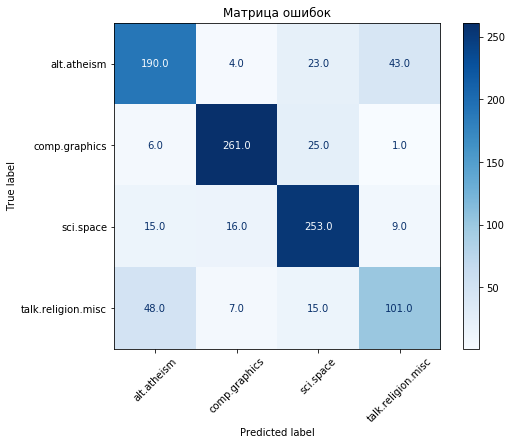

In [119]:
fig, ax = plt.subplots(figsize=(8, 6))
np.set_printoptions(precision=2)
disp = plot_confusion_matrix(clf, X_test, y_test,
                                 display_labels=class_names,
                                 cmap=plt.cm.Blues,
                                 normalize=None, ax=ax, values_format='.1f',)

disp.ax_.set_title('Матрица ошибок')
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names, rotation=45)
plt.show()

In [120]:
cur_rep = classification_report(y_test, y_pred , target_names=class_names)
print('Словарь из топа категорий + CountVectorizer\n\n')
print(cur_rep)

Словарь из топа категорий + CountVectorizer


                    precision    recall  f1-score   support

       alt.atheism       0.73      0.73      0.73       260
     comp.graphics       0.91      0.89      0.90       293
         sci.space       0.80      0.86      0.83       293
talk.religion.misc       0.66      0.59      0.62       171

          accuracy                           0.79      1017
         macro avg       0.77      0.77      0.77      1017
      weighted avg       0.79      0.79      0.79      1017



In [121]:
cr_cur, macro_avg_cur = report2array(classification_report(y_test, y_pred))

In [122]:
print('Разница в macro avg: {:.2f}\n'.format(macro_avg_cur-macro_avg_old))
print('Разница в показателях с предыдущим отчетом:\n\nprecision/recall/f1-score\n{}'.format(cr_cur - cr_old))

Разница в macro avg: -0.03

Разница в показателях с предыдущим отчетом:

precision/recall/f1-score
[[ 0.   -0.04 -0.02]
 [ 0.01 -0.01  0.  ]
 [-0.04 -0.02 -0.03]
 [-0.09 -0.05 -0.07]]


In [123]:
print('Разница в macro avg: {:.2f}\n'.format(macro_avg_cur - macro_avg_best))
print('Разница в показателях с лучшим отчетом:\n\nprecision/recall/f1-score\n{}'.format(cr_cur - cr_best))

Разница в macro avg: -0.04

Разница в показателях с лучшим отчетом:

precision/recall/f1-score
[[ 0.02 -0.09 -0.03]
 [-0.03 -0.01 -0.02]
 [-0.06 -0.01 -0.03]
 [-0.12 -0.06 -0.09]]


In [124]:
show_top10(clf, X_voc, class_names, top=10)

alt.atheism: [christian bible morality statement moral evidence atheist argument belief claim]
comp.graphics: [email color advance windows format code file computer resolution graphics]
sci.space: [flight project spacecraft satellite mission solar moon launch shuttle orbit]
talk.religion.misc: [self argument claim faith children evidence word christians christian bible]


### Исключение слов из статей  
У меня уже есть отдельные словари для каждой из статей, попробую исключить некоторые слова из статей. К примеру из атеизма слова, которые имеют большой вес в религии.

In [125]:
class_names

array(['alt.atheism', 'comp.graphics', 'sci.space', 'talk.religion.misc'],
      dtype=object)

In [126]:
def CelarSameWords(bow=voc_data, vocs=vocs, cats=class_names):
    '''
    Ищет одинаковые слова в каждой категории и исключает их из общего BOW
    В итоге в BOW только "уникальные" слова для каждой категории
    '''
    keys_count = len(vocs.keys())
    keys_indx = list(range(0,keys_count))
    for k in keys_indx:
        keys_for_clear =  keys_indx.copy()
        keys_for_clear.remove(k) #индексы словарей для поиска одинаковых слов и очистке
        for key_for_clear in keys_for_clear:
            #одинаковые слова 2х категорий
            same_words = set(vocs["voc_{}".format(k)]) & set(vocs["voc_{}".format(key_for_clear)])
            #исключею из общего словаря одинаковые слова
            bow = list(set(bow)-same_words)
    return bow

--------Тест-----

In [127]:
#Тестовый набор данных
df_tmp = pd.DataFrame()
df_tmp['text_f3'] = 2*['aarr aagg aarr aaaa', 'ggss gggg ggggg aagg', 'ggss ssss sssss ssrr', 'aarr ssrr aarr rrrr'] 
df_tmp['target'] = 2*[0,1,2,3]
df_tmp.head(4)

,text_f3,target
0,aarr aagg aarr aaaa,0
1,ggss gggg ggggg aagg,1
2,ggss ssss sssss ssrr,2
3,aarr ssrr aarr rrrr,3


In [128]:
#словарь из слов каждой категории
vocs_tmp = vocs_for_category(df=df_tmp.copy())
vocs_tmp

{'voc_0': array(['aaaa', 'aagg', 'aarr'], dtype=object),
 'voc_1': array(['aagg', 'gggg', 'ggggg', 'ggss'], dtype=object),
 'voc_2': array(['ggss', 'ssrr', 'ssss', 'sssss'], dtype=object),
 'voc_3': array(['aarr', 'rrrr', 'ssrr'], dtype=object)}

In [129]:
#словарь объединенный один список
voc_data_tmp = list(itertools.chain.from_iterable([*vocs_tmp.values()]))
voc_data_tmp

['aaaa',
 'aagg',
 'aarr',
 'aagg',
 'gggg',
 'ggggg',
 'ggss',
 'ggss',
 'ssrr',
 'ssss',
 'sssss',
 'aarr',
 'rrrr',
 'ssrr']

In [130]:
#Только уникальные слова, не повторяющиеся в других категориях
bow_uniq_tmp = CelarSameWords(bow=voc_data_tmp, vocs=vocs_tmp, cats=class_names)
bow_uniq_tmp

['ssss', 'rrrr', 'gggg', 'ggggg', 'sssss', 'aaaa']

In [131]:
vectorizer_tmp = CountVectorizer(vocabulary=bow_uniq_tmp)
vectorizer_tmp.vocabulary

['ssss', 'rrrr', 'gggg', 'ggggg', 'sssss', 'aaaa']

In [132]:
vectorizer_tmp.transform(['aarr aagg aarr aaaa']).toarray()

array([[0, 0, 0, 0, 0, 1]])

#-------Тест-----

!!! ----------Перенести в раздел пайплайнов

In [133]:
from sklearn.pipeline import Pipeline
from tqdm import tqdm

In [134]:
#перебор параметров подготовки словаря
pipe_flag=False

if pipe_flag:
    for topwords_perc in [[1,1,1,1],[0.99,0.99,0.99,0.99],[0.98,0.98,0.98,0.98],[0.97,0.97,0.97,0.97],[0.5,0.99,0.99,0.99],[0.2,0.99,0.99,0.99]]:
        #получаю словарь из процента топ слов каждой категории
        vocs = vocs_for_category(df.copy(), topwords_perc=topwords_perc,cv_max_df=1.0,cv_min_df=1)
        #формирую итоговый список слов для мешка слов
        voc_data = list(itertools.chain.from_iterable([*vocs.values()]))
        print('\n\n===Старт с параметрами: {}'.format(topwords_perc))
        #убираю слова, которые есть в словаре каждой категории. в каждой категории только слова которые встречаются в этой категории
        bow_uniq = CelarSameWords(voc_data.copy())
        print('   Слов было: {}, стало:{}'.format(len(voc_data),len(bow_uniq)))
        #формирую пайплан
        pipeline = Pipeline([
            ('count_vectorizer', CountVectorizer(
              vocabulary=bow_uniq, #использую свой подготовленный словарь
            )),
            ('clf', MultinomialNB())
        ])
        parameters = {
            'count_vectorizer__max_df': [1.0,0.02,0.05,0.09,0.12,0.15,0.25],
            'count_vectorizer__min_df': [1,2,3,4,5],
            'count_vectorizer__ngram_range': [(1, 1),(1, 2),(1, 3),(2, 2),(2, 3)],
            'clf__alpha': [1,2,3]
        }
    
        cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
        search = GridSearchCV(pipeline, parameters , cv=cv, verbose=0,n_jobs=2, scoring='accuracy')                    
    
        %time search.fit(X_train_orig, y_train)
        print("### BEST: score={}, params={}".format(search.best_score_, search.best_params_))

------------------------------#

Модель по лучшим параметрам:

In [135]:
#X = df['text']
X = df['text_f3']
y = df['target'].astype('int')
X_train_orig, X_test_orig, y_train, y_test = train_test_split(X, y, random_state=42, test_size=0.3)

In [136]:
best_topwords_perc = [1,1,1,1]
cv_max_df=1.0 #Параметры для CountVectorizer default 1.0
cv_min_df= 1 #Параметры для CountVectorizer default 1
cv_ngram_range=(1, 1) #Параметры для CountVectorizer default=(1, 1)
best_alpha = 1

In [137]:
vocs = vocs_for_category(df.copy(),col_name='text_f3',topwords_perc=best_topwords_perc,cv_max_df=1.0,cv_min_df=1)

In [138]:
#сформирую итоговый список слов для мешка слов
voc_data = list(itertools.chain.from_iterable([*vocs.values()]))
len(voc_data)

37327

In [139]:
#Слова уникальные для каждой категории, не повторяющиеся в других
bow_uniq = CelarSameWords(voc_data.copy())
print('Было слов: {}, стало:{}'.format(len(voc_data),len(bow_uniq)))

Было слов: 37327, стало:17177


In [140]:
vectorizer = CountVectorizer(max_df=cv_max_df, min_df=cv_min_df,\
                             ngram_range=cv_ngram_range,\
                             vocabulary=bow_uniq,
                            stop_words='english')

X_train = vectorizer.transform(X_train_orig)
X_test =  vectorizer.transform(X_test_orig)

#X_train = tfidf_transformer.fit_transform(X_train)
#X_test = tfidf_transformer.transform(X_test)

In [141]:
clf = MultinomialNB(alpha=best_alpha)
clf.fit(X_train, y_train)

MultinomialNB(alpha=1, class_prior=None, fit_prior=True)

In [142]:
y_pred = clf.predict(X_test)

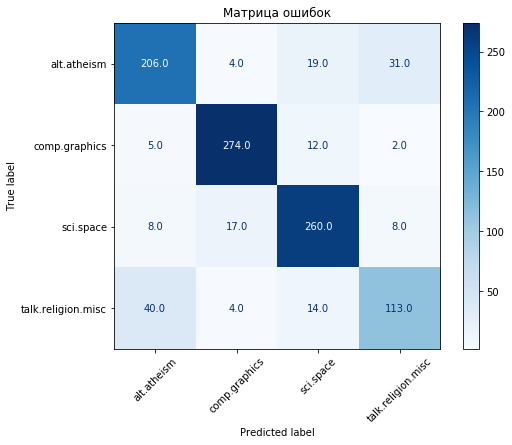

In [143]:
fig, ax = plt.subplots(figsize=(8, 6))
np.set_printoptions(precision=2)
disp = plot_confusion_matrix(clf, X_test, y_test,
                                 display_labels=class_names,
                                 cmap=plt.cm.Blues,
                                 normalize=None, ax=ax, values_format='.1f',)

disp.ax_.set_title('Матрица ошибок')
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names, rotation=45)
plt.show()

In [144]:
cur_rep = classification_report(y_test, y_pred , target_names=class_names)
print('Словарь с вычетом повторяющихся слов + CountVectorizer\n\n')
print(cur_rep)

Словарь с вычетом повторяющихся слов + CountVectorizer


                    precision    recall  f1-score   support

       alt.atheism       0.80      0.79      0.79       260
     comp.graphics       0.92      0.94      0.93       293
         sci.space       0.85      0.89      0.87       293
talk.religion.misc       0.73      0.66      0.70       171

          accuracy                           0.84      1017
         macro avg       0.82      0.82      0.82      1017
      weighted avg       0.84      0.84      0.84      1017



In [145]:
cur_rep = classification_report(y_test, y_pred , target_names=class_names)
print('Словарь с вычетом повторяющихся слов + CountVectorizer\n\n')
print(cur_rep)

Словарь с вычетом повторяющихся слов + CountVectorizer


                    precision    recall  f1-score   support

       alt.atheism       0.80      0.79      0.79       260
     comp.graphics       0.92      0.94      0.93       293
         sci.space       0.85      0.89      0.87       293
talk.religion.misc       0.73      0.66      0.70       171

          accuracy                           0.84      1017
         macro avg       0.82      0.82      0.82      1017
      weighted avg       0.84      0.84      0.84      1017



In [146]:
print('Разница в macro avg: {:.2f}\n'.format(macro_avg_cur - macro_avg_best))
print('Разница в показателях с лучшим отчетом:\n\nprecision/recall/f1-score\n{}'.format(cr_cur - cr_best))

Разница в macro avg: -0.04

Разница в показателях с лучшим отчетом:

precision/recall/f1-score
[[ 0.02 -0.09 -0.03]
 [-0.03 -0.01 -0.02]
 [-0.06 -0.01 -0.03]
 [-0.12 -0.06 -0.09]]


### Посмотрю подробнее на статьи предсказанные ошибочно

In [147]:
#Нужно посмотреть на тексты, которые ошибочно предсказываеются. например в религии

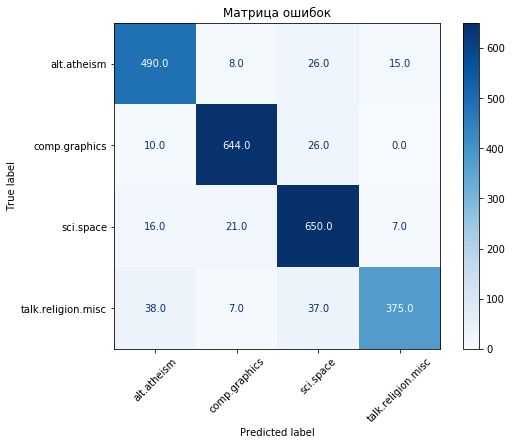

In [148]:
#Возьму тренеровочные данные, на которых проводил обучение
#Почему-то на них тоже достаточно ошибок, хотя я чистил словарь от повторяющихся слов
#Должно же было заоверфититься?

y_pred = clf.predict(X_train)

fig, ax = plt.subplots(figsize=(8, 6))
np.set_printoptions(precision=2)
disp = plot_confusion_matrix(clf, X_train, y_train,
                                 display_labels=class_names,
                                 cmap=plt.cm.Blues,
                                 normalize=None, ax=ax, values_format='.1f',)

disp.ax_.set_title('Матрица ошибок')
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names, rotation=45)
plt.show()

In [149]:
train_data_for_x = X_train
train_data_for_y = y_train


df_y_test = train_data_for_y.reset_index()
df_y_test['pred'] = clf.predict(train_data_for_x)
df_y_test.head()

,index,target,pred
0,47,0,0
1,3053,2,2
2,380,1,1
3,1884,0,0
4,328,1,1


In [150]:
df_y_test.groupby(['target','pred'])['pred'].count()

target  pred
0       0       490
        1         8
        2        26
        3        15
1       0        10
        1       644
        2        26
2       0        16
        1        21
        2       650
        3         7
3       0        38
        1         7
        2        37
        3       375
Name: pred, dtype: int64

In [151]:
#Объединю данные, чтобы посмотреть текст статей
df_y_test = df_y_test.join(df,rsuffix='_y',on='index')
df_y_test.drop('target_y',axis=1,inplace=True)
df_y_test.head(2)

,index,target,pred,text,category,text_f3
0,47,0,0,"\n\n AH! But what, exactly, is ""inherentl...",alt.atheism,not abhorrent absolutely absolutism agree alik...
1,3053,2,2,\nIt would be nice if someone here from the HS...,sci.space,aerospace arrays begin bringing brit built cen...


In [152]:
class_names

array(['alt.atheism', 'comp.graphics', 'sci.space', 'talk.religion.misc'],
      dtype=object)

In [153]:
#Возьму атеизм как target и графику как pred
df_ag = df_y_test[(df_y_test['target']==0) & (df_y_test['pred']==1)]
df_ag.head()

,index,target,pred,text,category,text_f3
147,1608,0,1,[Frank's solution deleted.]\n\nIf you have acc...,alt.atheism,access check completly contact copy deleted fo...
241,1290,0,1,"Hello Gang,\n\nThere have been some notes rece...",alt.atheism,answer asking contact darwin email fish gang h...
835,444,0,1,"[By default, followups to 3 newsgroups.]\n\nA ...",alt.atheism,"[By default, followups to 3 newsgroups.]\n\nA ..."
969,1827,0,1,"\n""Manufacturing Consent,"" a film about the me...",alt.atheism,#numb #year #centr #numb #numblett #numb #numb...
1496,121,0,1,\nTail-recursive functions in Scheme are at le...,alt.atheism,assembler compilers doesn efficient functions ...


In [154]:
#Посмотрим на слова, которые в этих статьях и в трейновском словаре категории "графика"
vectorizer = CountVectorizer()
vect_ag = vectorizer.fit(df_ag['text_f3'])
vect_ag_tfidf = tfidf_transformer.fit(vect_ag.transform(df_ag['text_f3']))

In [155]:
rr = dict(zip(vect_ag.get_feature_names(), vect_ag_tfidf.idf_))
rr_voc = token_weight_df(rr,'word')
rr_voc.head(5)

,word,weight_word
0,access,2.504077
86,requires,2.504077
84,recursive,2.504077
83,recently,2.504077
82,readers,2.504077


In [156]:
#трейновские слова графики
vocs['voc_1']

array(['00', 'joint', 'tidbits', ..., 'graphics', 'know', 'numb'],
      dtype=object)

In [157]:
voc_ag = set(vect_ag.get_feature_names()) & set(vocs['voc_1']) #Слова которые есть и там и там
voc_ag_uniq = set(voc_ag) & set(bow_uniq)

In [158]:
print('Уникальных слов в тесте атеизма, которые предсказываются графикой: {}'.format(len(vect_ag.get_feature_names())))
print('  - из них содержатся в трейновском славаре графики : {}'.format(len(voc_ag)))
print('    - из них содержатся в трейновском словаре уникальных слов : {}'.format(len(voc_ag_uniq)))

Уникальных слов в тесте атеизма, которые предсказываются графикой: 117
  - из них содержатся в трейновском славаре графики : 79
    - из них содержатся в трейновском словаре уникальных слов : 51


... откуда эти 51 слова? Я же вычищал...

In [159]:
voc_ag 

{'access',
 'alternative',
 'answer',
 'asking',
 'assembler',
 'book',
 'broken',
 'canada',
 'centr',
 'check',
 'completly',
 'computer',
 'contact',
 'copy',
 'dame',
 'default',
 'deleted',
 'doesn',
 'efficient',
 'email',
 'entertainment',
 'explain',
 'file',
 'film',
 'films',
 'fish',
 'form',
 'frank',
 'free',
 'functions',
 'heard',
 'hello',
 'hogan',
 'international',
 'james',
 'kill',
 'know',
 'local',
 'longer',
 'manufacturing',
 'media',
 'movie',
 'need',
 'newsgroups',
 'normal',
 'notes',
 'notre',
 'numb',
 'numblett',
 'obtain',
 'output',
 'perfectly',
 'picture',
 'post',
 'program',
 'public',
 'question',
 'readers',
 'recently',
 'recursive',
 'reply',
 'requires',
 'sales',
 'scheme',
 'seen',
 'short',
 'solution',
 'somesize',
 'source',
 'tail',
 'telnet',
 'thanks',
 'theatre',
 'think',
 'try',
 'unix',
 'view',
 'washington',
 'year'}

In [160]:
bow_uniq2 = set(bow_uniq) - set(vect_ag.get_feature_names())

In [161]:
bow_uniq2

{'coming',
 'wheat',
 'capitol',
 'accumulation',
 'mayest',
 'partake',
 'calculater',
 'fileserver',
 'erected',
 'gaskins',
 'prime',
 'predicated',
 'tidal',
 'alunatic',
 'spychalla',
 'turbine',
 'footballs',
 'counterexample',
 'theory',
 'grids',
 'transparency',
 'colourlist',
 'prim',
 'mutations',
 'multicolor',
 'tribal',
 'spacewalking',
 'neue',
 'crowded',
 'beluisteren',
 'remained',
 'pruesse',
 'newsfeed',
 'tists',
 'prettier',
 'firsteps',
 'shifters',
 'convening',
 'donwloaded',
 'semantics',
 'deprogrammed',
 'spif',
 'rawlin',
 'nietzsche',
 'silverman',
 'arrayed',
 'mnemonics',
 'pomp',
 'geology',
 'interconnection',
 'ruby',
 'mauldin',
 'testimonies',
 'rawtopgm',
 'increaces',
 'minimize',
 'oprah',
 'framegrabber',
 'pulsar',
 'axion',
 'flyover',
 'appreshed',
 'scriptur',
 'arcmin',
 'skinner',
 'alarm',
 'raster',
 'scaleable',
 'reboosting',
 'sparse',
 'harden',
 'presure',
 'maps',
 'compassion',
 'shipment',
 'infiltrating',
 'discriminatory',
 'te

In [162]:
vectorizer = CountVectorizer(max_df=cv_max_df, min_df=cv_min_df,\
                             ngram_range=cv_ngram_range,\
                             vocabulary=bow_uniq2,
                            stop_words='english')

X_train = vectorizer.transform(X_train_orig)
X_test =  vectorizer.transform(X_test_orig)

In [163]:
clf = MultinomialNB(alpha=best_alpha)
clf.fit(X_train, y_train)

MultinomialNB(alpha=1, class_prior=None, fit_prior=True)

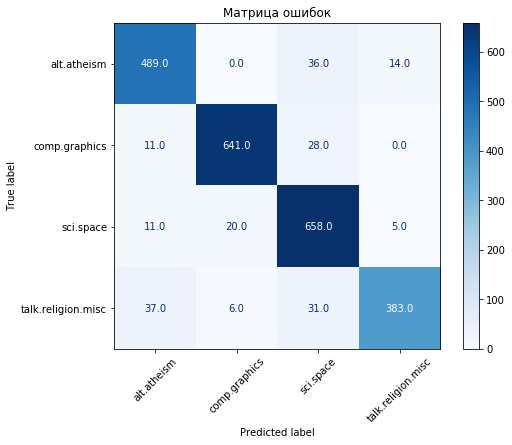

In [164]:
fig, ax = plt.subplots(figsize=(8, 6))
np.set_printoptions(precision=2)
disp = plot_confusion_matrix(clf, X_train, y_train,
                                 display_labels=class_names,
                                 cmap=plt.cm.Blues,
                                 normalize=None, ax=ax, values_format='.1f',)

disp.ax_.set_title('Матрица ошибок')
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names, rotation=45)
plt.show()

#### Ngram

In [165]:
#v = CountVectorizer(ngram_range=(3, 3))
#print(v.fit(["an apple a day keeps the doctor away"]).vocabulary_)

In [166]:
X = df['text']
#X = df['text_f3']
y = df['target'].astype('int')

In [167]:
X_train_orig, X_test_orig, y_train, y_test = train_test_split(X, y, random_state=42, test_size=0.3)

!!! ----------Перенести в раздел пайплайнов

In [168]:
pipe_flag=False

if pipe_flag:
    pipeline = Pipeline([
            ('count_vectorizer', CountVectorizer()),
            ('clf', MultinomialNB())
        ])
    parameters = {
            'count_vectorizer__max_df': [1.0,0.05,0.08,0.09,0.11,0.12,0.15,0.17,0.19,0.25],
            'count_vectorizer__min_df': [1,2,3,4,5],
            'count_vectorizer__ngram_range': [(1, 1),(1, 2),(1, 3),(2, 2),(2, 3)],
            'clf__alpha': [1,2,3]
        }
    
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    search = GridSearchCV(pipeline, parameters , cv=cv, verbose=0,n_jobs=2, scoring='accuracy')                    

    %%time
    search.fit(X_train_orig, y_train)
    print("BEST: score={}, params={}".format(search.best_score_, search.best_params_))

----------------------------#

Модель по лучшим параметрам:

In [169]:
cv_max_df=0.05#0.12 #Параметры для CountVectorizer default 1.0
cv_min_df=1 #Параметры для CountVectorizer default 1
cv_ngram_range=(1, 2) #Параметры для CountVectorizer default=(1, 1)

vectorizer= CountVectorizer(max_df=cv_max_df, min_df=cv_min_df,\
                             ngram_range=cv_ngram_range
                            ,stop_words='english')

X_train = vectorizer.fit_transform(X_train_orig)
X_test = vectorizer.transform(X_test_orig)

In [170]:
len(vectorizer.vocabulary_)

206579

In [171]:
clf = MultinomialNB(alpha=1)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

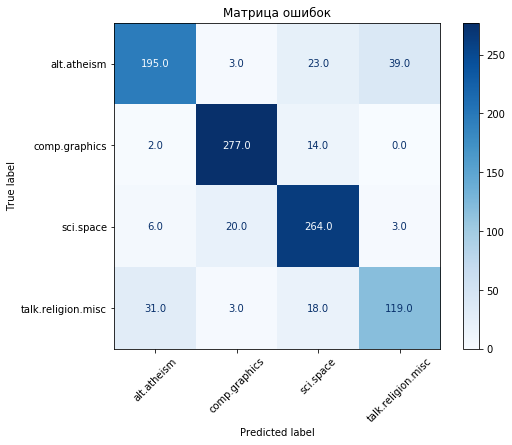

In [172]:
fig, ax = plt.subplots(figsize=(8, 6))
np.set_printoptions(precision=2)
disp = plot_confusion_matrix(clf, X_test, y_test,
                                 display_labels=class_names,
                                 cmap=plt.cm.Blues,
                                 normalize=None, ax=ax, values_format='.1f',)

disp.ax_.set_title('Матрица ошибок')
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names, rotation=45)
plt.show()

In [173]:
cur_rep = classification_report(y_test, y_pred , target_names=class_names)
print('Ngram + CountVectorizer\n\n')
print(cur_rep)

Ngram + CountVectorizer


                    precision    recall  f1-score   support

       alt.atheism       0.83      0.75      0.79       260
     comp.graphics       0.91      0.95      0.93       293
         sci.space       0.83      0.90      0.86       293
talk.religion.misc       0.74      0.70      0.72       171

          accuracy                           0.84      1017
         macro avg       0.83      0.82      0.82      1017
      weighted avg       0.84      0.84      0.84      1017



In [174]:
cr_cur, macro_avg_cur = report2array(classification_report(y_test, y_pred))

In [175]:
print('Разница в macro avg: {:.2f}\n'.format(macro_avg_cur - macro_avg_best))
print('Разница в показателях с лучшим отчетом:\n\nprecision/recall/f1-score\n{}'.format(cr_cur - cr_best))

Разница в macro avg: 0.01

Разница в показателях с лучшим отчетом:

precision/recall/f1-score
[[ 0.12 -0.07  0.03]
 [-0.03  0.05  0.01]
 [-0.03  0.03  0.  ]
 [-0.04  0.05  0.01]]


### Pipeline и перебор вариантов

In [176]:
#import itertools
reP_cv_parse_only = [True,False]

vfc_topwords_perc = [[1,1,1,1],[0.99,0.99,0.99,0.99],[0.98,0.98,0.98,0.98],[0.97,0.97,0.97,0.97],[0.5,0.99,0.99,0.99],[0.2,0.99,0.99,0.99]]
vfc_cv_max_df=[1.0,0.02,0.05]
vfc_cv_min_df = [1,2]
vfc_cv_ngram = [(1, 1),(1, 2),(2, 2)]
vfc_col_name = ['text','text_f3']
vfc_cv_stopwords = [True,False]

use_csw = [True,False]
use_tfidf = [True,False]

combinations = list(itertools.product(reP_cv_parse_only,\
                       vfc_topwords_perc,vfc_cv_max_df,vfc_cv_min_df,vfc_cv_ngram,vfc_cv_stopwords,\
                      use_csw,
                      use_tfidf))
len(combinations)

1728

In [177]:
#перебор параметров подготовки словаря
pipe_flag=False

if pipe_flag:
    for topwords_perc in [[1,1,1,1],[0.99,0.99,0.99,0.99],[0.98,0.98,0.98,0.98],[0.97,0.97,0.97,0.97],[0.5,0.99,0.99,0.99],[0.2,0.99,0.99,0.99]]:
        #получаю словарь из процента топ слов каждой категории
        vocs = vocs_for_category(df.copy(), topwords_perc=topwords_perc,cv_max_df=1.0,cv_min_df=1)
        #формирую итоговый список слов для мешка слов
        voc_data = list(itertools.chain.from_iterable([*vocs.values()]))
        print('\n\n===Старт с параметрами: {}'.format(topwords_perc))
        if (use_csw):
            #убираю слова, которые есть в словаре каждой категории. в каждой категории только слова которые встречаются в этой категории
            bow_uniq = CelarSameWords(voc_data.copy())          
            #формирую пайплан
            pipeline = Pipeline([
                ('count_vectorizer', CountVectorizer(
                  vocabulary=bow_uniq, #использую свой подготовленный словарь
                )),
            ('clf', MultinomialNB())
        ])
        parameters = {
            'count_vectorizer__max_df': [1.0,0.02,0.05,0.09,0.15,0.25],
            'count_vectorizer__min_df': [1,2,3],
            'count_vectorizer__ngram_range': [(1, 1),(1, 2),(1, 3),(2, 2),(2, 3)],
            'clf__alpha': [1,2,3]
        }
    
        cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
        search = GridSearchCV(pipeline, parameters , cv=cv, verbose=0,n_jobs=2, scoring='accuracy')                    
    
        %time search.fit(X_train_orig, y_train)
        print("### BEST: score={}, params={}".format(search.best_score_, search.best_params_))

### word2vec

In [178]:
#https://gitlab.com/AlexBut/course-task/-/blob/master/Project.ipynb - тут есть примеры работы с word2vec

In [179]:
from gensim.models import word2vec

In [180]:
def format_text(txt):
    txt = re.sub('[^a-zA-Z0-9 ]', '', txt)
    txt = txt.replace('  ',' ').lower()
    return txt

взять токенайзер, NLTK

In [181]:
df['text_w2v'] = df['text'].apply(lambda t: format_text(t).strip().split(' '))

In [182]:
df['text_w2v']

0       [my, point, is, that, you, set, up, your, view...
9       [the, corrupted, over, and, over, theory, is, ...
14      [but, you, wouldnt, know, what, red, was, and,...
26      [well, i, agree, with, you, in, the, sense, th...
27      [specifically, which, changes, are, you, talki...
                              ...                        
3370    [phil, didnt, one, of, the, early, jet, fighte...
3373    [where, did, that, idea, come, from, its, news...
3378    [wasnt, there, a, plain, flavor, too, they, lo...
3383    [did, the, russian, spacecrafts, on, the, illf...
3384    [oh, gee, a, billion, dollars, thatd, be, just...
Name: text_w2v, Length: 3387, dtype: object

In [183]:
X = df['text_w2v']
y = df['target'].astype('int')
X_train_orig, X_test_orig, y_train, y_test = train_test_split(X, y, random_state=42, test_size=0.3)

In [184]:
X_train_orig[:2]

47      [ah, but, what, exactly, is, inherently, abhor...
3053    [it, would, be, nice, if, someone, here, from,...
Name: text_w2v, dtype: object

In [185]:
w2v = word2vec.Word2Vec(X_train_orig[:2], size=300, window=5)

Взять обученны вордтувек

In [186]:
w2v_dict = dict(zip(w2v.wv.index2word, w2v.wv.syn0))
word_vectors = pd.DataFrame(w2v.wv.vectors, index=w2v.wv.index2word)

/home/denis/.pyenv/versions/3.7.1/lib/python3.7/site-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `syn0` (Attribute will be removed in 4.0.0, use self.vectors instead).
  """Entry point for launching an IPython kernel.


??? Почему так мало слов?

In [187]:
w2v.wv.vectors.shape

(12, 300)

In [188]:
word_vectors.index

Index(['the', 'is', '', 'i', 'are', 'that', 'in', 'to', 'and', 'it', 'a',
       'of'],
      dtype='object')

In [189]:
w2v.wv.most_similar(positive=['jesus'], topn=5)

KeyError: "word 'jesus' not in vocabulary"

Т.к. сейчас мы каждому слову сопоставили вектор, то нужно решить, что сопоставить целому предложению из слов.
Один из возможных вариантов это просто усреднить все слова в предложении и получить некоторый смысл всего предложения (если слова нет в тексте, то берем нулевой вектор).

In [ ]:
class mean_vectorizer(object):
    def __init__(self, word2vec):
        self.word2vec = word2vec
        self.dim = len(next(iter(w2v_dict.values())))

    def fit(self, X):
        return self 

    def transform(self, X):
        return np.array([
            np.mean([self.word2vec[w] for w in words if w in self.word2vec] 
                    or [np.zeros(self.dim)], axis=0)
            for words in X
        ])

In [ ]:
X_train = mean_vectorizer(w2v).fit(X_train_orig).transform(X_train_orig)
X_test = mean_vectorizer(w2v).fit(X_test_orig).transform(X_test_orig)

print(X_train.shape, X_test.shape)

In [ ]:
from sklearn.ensemble import ExtraTreesClassifier
from xgboost import XGBClassifier

In [ ]:
clf_etc = ExtraTreesClassifier()
clf_etc.fit(X_train,y_train.astype(int))

In [ ]:
clf_xgb = XGBClassifier()
clf_xgb.fit(X_train,y_train.astype(int))

In [ ]:
#clf=clf_etc
clf=clf_xgb
y_pred = clf.predict(X_test)

In [ ]:
fig, ax = plt.subplots(figsize=(8, 6))
np.set_printoptions(precision=2)
disp = plot_confusion_matrix(clf, X_test, y_test.astype(int),
                                 display_labels=class_names,
                                 cmap=plt.cm.Blues,
                                 normalize=None, ax=ax, values_format='.1f',)

disp.ax_.set_title('Матрица ошибок')
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names, rotation=45)
plt.show()

In [ ]:
cur_rep = classification_report(y_test, y_pred , target_names=class_names)
print('Word2vec\n\n')
print(cur_rep)

In [ ]:
cr_cur, macro_avg_cur = report2array(classification_report(y_test, y_pred))

In [190]:
print('Разница в macro avg: {:.2f}\n'.format(macro_avg_cur - macro_avg_best))
print('Разница в показателях с лучшим отчетом:\n\nprecision/recall/f1-score\n{}'.format(cr_cur - cr_best))

Разница в macro avg: 0.01

Разница в показателях с лучшим отчетом:

precision/recall/f1-score
[[ 0.12 -0.07  0.03]
 [-0.03  0.05  0.01]
 [-0.03  0.03  0.  ]
 [-0.04  0.05  0.01]]


In [ ]:
#SVD разложение до 1000 фичей
#+визуализация
#SGDClassifier(loss='hinge', penalty='l2',alpha=1e-3, random_state=42, max_iter=5, tol=None))